In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed0
# For example, here's several helpful packages to load in 
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
#from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation , Dropout
from keras import backend as K
from keras.optimizers import Adam, Adamax,SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/UFS/F2 - Copia/database"))

# Any results you write to the current directory are saved as output.

['mitbih_test.csv', 'mitbih_test.csv.zip', 'mitbih_train.csv', 'mitbih_train.csv.zip', 'ptbdb_abnormal.csv', 'ptbdb_abnormal.csv.zip', 'ptbdb_normal.csv', 'ptbdb_normal.csv.zip']


In [5]:
train_df = pd.read_csv("/UFS/F2 - Copia/database/mitbih_train.csv", header=None)
test_df = pd.read_csv("/UFS/F2 - Copia/database/mitbih_test.csv", header=None)
#df = pd.concat([df, df2], axis=0)

In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_df.info()
dataset_row = train_df.shape[0]
dataset_size= int(dataset_row/5)
print(dataset_size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
17510


In [8]:
train_df[187]=train_df[187].astype(int)
equilibre= train_df[187].value_counts()
print(equilibre)



0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [9]:
train_df[187].value_counts()
equilibre = train_df[187].value_counts()

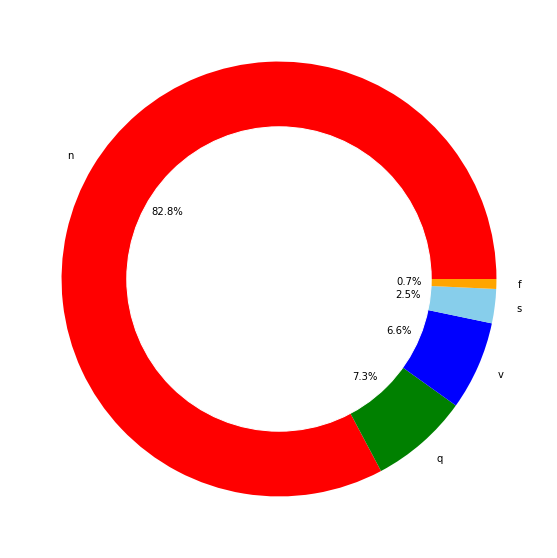

In [10]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [11]:
M = train_df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [12]:
#del train_df
#del test_df
#del M

In [13]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)


In [14]:
#tempo=c.iloc[0,:186]
#bruiter=add_gaussian_noise(tempo)

#plt.subplot(2,1,1)
#plt.plot(c.iloc[0,:186])

#plt.subplot(2,1,2)
#plt.plot(bruiter)

#plt.show()



In [15]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [16]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [17]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

# Data augmentation

To train properly the model, we sould have to augment all data to the same level. Nevertheless, for a first try, we will just augment the smallest class to the same level as class 1. With that we will be able to have a test set of around 5x800 observations.

# Split

In [18]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (87554, 186, 1)
y_train (87554, 5)
X_test (21892, 186, 1)
y_test (21892, 5)


# Model

Now let's re-create the model from the ArXiv Document

In [19]:
n_obs, feature, depth = X_train.shape
batch_size = 1500
#batch_size = 500

In [20]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)
C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C13 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
C14 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C13)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C14)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
#M11 = MaxPooling1D(pool_size=5, strides=2)(A12)

C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A12)
A21 = Activation("relu")(C21)
C23 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
C24 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C23)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C24)
S21 = Add()([C22, S11])
A22 = Activation("relu")(C21)
#M21 = MaxPooling1D(pool_size=5, strides=2)(A22)

C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A22)
A31 = Activation("relu")(C31)
C34 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
C33 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C34)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C33)
S31 = Add()([C32, S21])
A32 = Activation("relu")(S31)
#M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A32)
A41 = Activation("relu")(C41)
C43 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
C44 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C43)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C44)
S41 = Add()([C42, S31])
A42 = Activation("relu")(S41)
#M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A42)
A51 = Activation("relu")(C51)
C53 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
C54 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C53)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C54)
S51 = Add()([C52, S41])
A52 = Activation("relu")(S51)
#M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

M52 = (Dropout(0.1))(A52)

F1 = Flatten()(M52)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 32), dtype=tf.float32, name=None), name='conv1d_17/BiasAdd:0', description="created by layer 'conv1d_17'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2, 32), dtype=tf.float32, name=None), name='max_pooling1d_4/Squeeze:0', description="created by layer 'max_pooling1d_4'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 186, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 182, 32)      192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 182, 32)      5152        ['

In [21]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [22]:
#adam = SGD(learning_rate = 0.01)
adam = Adamax(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [ ]:
#model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
#epochs = 0
batch_range = [ 1500, 2500]#20, 100, 500, 1500, 2500
epochs_range= [75,100]#25,50,75,100
loss_range=['categorical_crossentropy','binary_crossentropy']#'categorical_crossentropy','binary_crossentropy','huber_loss','kullback_leibler_divergence','poisson'
n=0
i=0
t=0
#optimizer_range= [adamax,adam]
#itertools
for lsr in loss_range:
    print(f"Loss: {loss_range[t]}")
    for ep in epochs_range:
        print(f"Epoch number: {ep}")
        for bs in batch_range:
            print(f"fitting with batch size: {bs}")
            model.compile(loss= loss_range[t], optimizer= adam, metrics=['accuracy'])
            history = model.fit(X_train, y_train, 
                                epochs=epochs_range[i], 
                                batch_size=batch_range[n], 
                                verbose=2, 
                                validation_data=(X_test, y_test), 
                                callbacks=[lrate])
            n = n+1
        n=0    
        i=i+1
    i=0
    t=t + 1
t= 0       

Loss: categorical_crossentropy
Epoch number: 75
fitting with batch size: 1500
Epoch 1/75


KeyboardInterrupt: 

In [23]:
model.compile(loss= 'categorical_crossentropy', optimizer= adam, metrics=['accuracy'])
history = model.fit(X_train, y_train, 
                                epochs=100, 
                                batch_size=2500, 
                                verbose=2, 
                                validation_data=(X_test, y_test), 
                                callbacks=[lrate])

Epoch 1/100
36/36 - 25s - loss: 0.7247 - accuracy: 0.8055 - val_loss: 1.0598 - val_accuracy: 0.8276 - lr: 0.0010 - 25s/epoch - 692ms/step
Epoch 2/100
36/36 - 13s - loss: 0.6427 - accuracy: 0.8277 - val_loss: 0.9983 - val_accuracy: 0.8276 - lr: 0.0010 - 13s/epoch - 362ms/step
Epoch 3/100
36/36 - 13s - loss: 0.6271 - accuracy: 0.8277 - val_loss: 0.9617 - val_accuracy: 0.8276 - lr: 0.0010 - 13s/epoch - 362ms/step
Epoch 4/100
36/36 - 13s - loss: 0.6100 - accuracy: 0.8278 - val_loss: 0.9024 - val_accuracy: 0.8276 - lr: 0.0010 - 13s/epoch - 365ms/step
Epoch 5/100
36/36 - 13s - loss: 0.5883 - accuracy: 0.8313 - val_loss: 0.8221 - val_accuracy: 0.8276 - lr: 0.0010 - 13s/epoch - 365ms/step
Epoch 6/100
36/36 - 13s - loss: 0.5593 - accuracy: 0.8411 - val_loss: 0.7221 - val_accuracy: 0.8588 - lr: 0.0010 - 13s/epoch - 365ms/step
Epoch 7/100
36/36 - 13s - loss: 0.5313 - accuracy: 0.8484 - val_loss: 0.7447 - val_accuracy: 0.8558 - lr: 0.0010 - 13s/epoch - 365ms/step
Epoch 8/100
36/36 - 13s - loss: 0.

In [ ]:
y_pred = model.predict(X_test, batch_size = 500)

44/44 [==============================] - 2s 33ms/step


In [ ]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     18118
           1       0.20      0.70      0.31       556
           2       0.66      0.83      0.73      1448
           3       0.07      0.92      0.13       162
           4       0.61      0.96      0.74      1608

    accuracy                           0.75     21892
   macro avg       0.50      0.83      0.55     21892
weighted avg       0.91      0.75      0.80     21892



In [ ]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test, y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test, y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(y_test, y_pred)))

ranking-based average precision : 0.867
Ranking loss : 0.077
Coverage_error : 1.306


Normalized confusion matrix


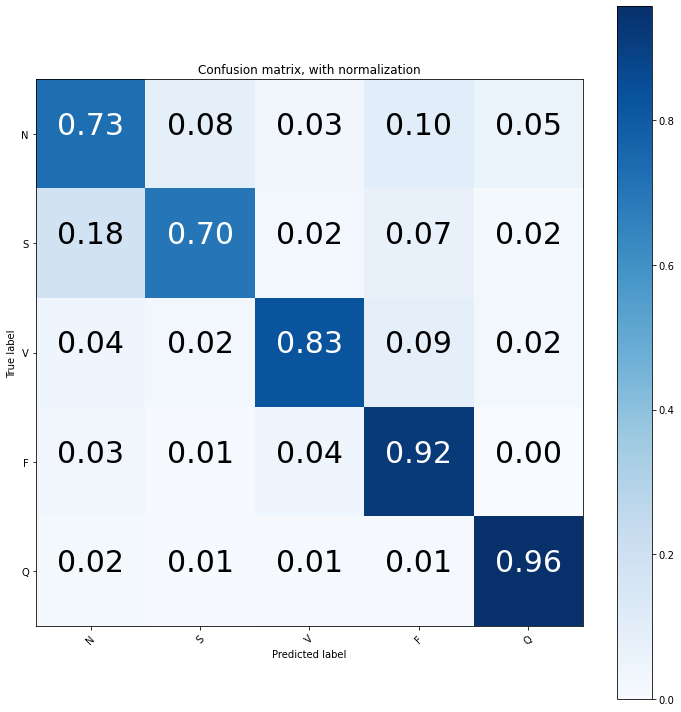

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
RECALL = TP/(TP+FN)
# Specificity or true negative rate
SPECIFICITY = TN/(TN+FP) 
# Precision or positive predictive value
PRECISION = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
#F1-score
F1 = 2*((RECALL*PRECISION)/(RECALL+PRECISION))

In [ ]:
from statistics import mean, median
from tkinter import N
scores = model.evaluate((X_test), y_test, batch_size = 500)
scores2 = model.evaluate(X_test, y_pred, batch_size = 500)
print("Accuracy: %.2f%%" % (scores[0]*100))
print("Accuracy: %.2f%%" % (scores[1]*100))
PRE = mean(PRECISION)
print("Precision: %.2f%%"% (PRE*100))
#print("Precision: ", PRECISION)
SPE = mean(SPECIFICITY)
print("Specificity: %.2f%%"% (SPE*100))
#print("Specificity", SPECIFICITY)
RE = mean(RECALL)
print("Recall :%.2f%%"% (RE*100))
#print("Recall", RECALL)
#print("F1: ", F1)
F1S = mean(F1)
print("F1-Score :%.2f%%"% (F1S*100))
Z= mean(1-FNR)*100
print("Recall:%.2f%%"%Z)

44/44 [==============================] - 2s 37ms/step - loss: 0.8328 - accuracy: 1.0000
Accuracy: 72.04%
Accuracy: 75.18%
Precision: 50.38%
Specificity: 94.02%
Recall :82.63%
F1-Score :55.00%
Recall:82.63%
